In [2481]:
import os
# os.environ['CXX'] = '/usr/bin/g++'
# os.environ['CXXFLAGS'] = '-I/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1'

#os.environ['CXXFLAGS'] = '-I/Library/Developer/CommandLineTools/usr/lib/clang/16/include -I/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include -I/Library/Developer/CommandLineTools/usr/include'
os.environ["PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:" + os.environ["PATH"]
os.environ["PKG_CONFIG_PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/pkgconfig:" + os.environ.get("PKG_CONFIG_PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

# Verify if paths are set correctly
print("PATH:", os.environ["PATH"])
print("PKG_CONFIG_PATH:", os.environ["PKG_CONFIG_PATH"])
print("LD_LIBRARY_PATH:", os.environ["LD_LIBRARY_PATH"])

PATH: /Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi

In [2482]:
import dolfin as dl
import ufl

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *

import logging
import math
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

# Objective:- Calculate the Jacovian matrix of state variable with respect to parameter. 
# $\Omega \in \mathbb{R}^n$ , n = 1, 2 or 3
# $ -\nabla  (k \nabla u) =f $
# Solve for 1D 
$$ - \nabla  (k \nabla u)  = x $$
# BC's are 
$$ u(0) = 0 $$
$$ u(1) = 1 $$

In [2483]:
# create mesh and define function spaces
# Define mesh
n = 1000
mesh = dl.UnitIntervalMesh(n)  # 1D mesh with 50 elements
oder =1
Vk = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', oder)
a = dl.Constant(1000)  # You can modify this value as needed
# # The true and inverted parameter
ktrue_expression = dl.Expression(
    '1 +  a * x[0]', a = a,
    degree=0)
ktrue = dl.interpolate(ktrue_expression,Vk)
print(ktrue.vector().get_local())
# ktrue = dl.Constant(2.0)
# define function for state and adjoint
u = dl.Function(Vu)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, p_trial, k_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vu), dl.TrialFunction(Vk)
u_test, p_test, k_test = dl.TestFunction(Vu), dl.TestFunction(Vu), dl.TestFunction(Vk)

# Define f(x) for the right-hand side (for simplicity, we choose f(x) = x)
f_expression = dl.Expression("x[0]", degree=1)
f = dl.interpolate(f_expression,Vu)  

class LeftBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) < dl.DOLFIN_EPS

class RightBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1) < dl.DOLFIN_EPS

boundary_parts = dl.MeshFunction("size_t", mesh, mesh.topology().dim()-1)
#boundary_parts = FacetFunction("size_t", mesh)
boundary_parts.set_all(0)


Gamma_left = LeftBoundary()
Gamma_left.mark(boundary_parts, 1)
Gamma_right = RightBoundary()
Gamma_right.mark(boundary_parts, 2)

u_L = dl.Constant(0.)
u_R = dl.Constant(1.)

bc_state = [dl.DirichletBC(Vu, u_L, boundary_parts, 1),
       dl.DirichletBC(Vu, u_R, boundary_parts, 2)]
bc_adj = [dl.DirichletBC(Vu, dl.Constant(0), boundary_parts, 1),
       dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 2)]


[1.000e+00 2.000e+00 3.000e+00 ... 9.990e+02 1.000e+03 1.001e+03]


# Weak form of the equation
$$(k \nabla u, \nabla p) - (f,p) =0$$
# Cost functional can be formed as 
$$J_i(u) = \int_{\Omega} \delta(x-x_i) u d\Omega$$ 
, where  $\delta(x-x_i)$  is Dirac's Delta function and $x_i$ is the i-th node
## If we add the PDE with cost fucntion with Langerange multiplier
$$L_i = (\delta(x-x_i), u) + (k \nabla u, \nabla p) - (f,p) $$
where $(u,v) = \int_{\Omega} u.v d\Omega$
#
## Adjoint equation become
$$ (\delta(x-x_i), \tilde(u)) + (k \nabla \tilde(u), \nabla p) =0$$ 

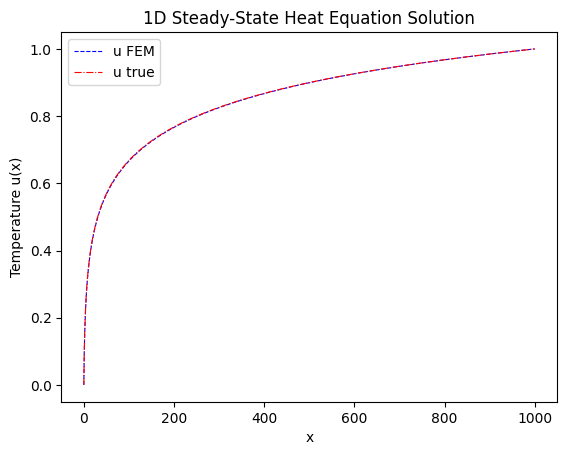

In [2484]:
# We added our weak formulation to the cost functional to form the Langerangian 
##########################################################################################
# weak form for setting up the state equation
##########################################################################################

a_state = ufl.inner( ktrue * ufl.grad(u_trial), ufl.grad(u_test)) * ufl.dx
L_state = f * u_test * ufl.dx

###########################################################################################
# solve state equation
###########################################################################################

state_A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve (state_A, u.vector(), state_b)


x_coord =mesh.coordinates()
x_coord = np.array(x_coord).reshape(-1)
#u_true = -(x_coord**3)/(6* ktrue.vector().get_local()) + (1 + 1/( 6 * ktrue.vector().get_local()))*x_coord #(-x^3/6k + (1+1/6k)x) # Here k =1
#u_true = (x_coord - x_coord**3)/12 #(-x^3/6k + (1+1/6k)x) # Here k =1

# u_true = -x^2/4 + x/2 + 3/(4 ln2) * ln(k)
#u_true = - x_coord**2/4 + x_coord/2 + (3/(np.log(16)))* np.log(1+x_coord)

u_true =  - x_coord**2/(4 * a.values()) + x_coord/(2 * a.values() * a.values()) + (1 + 1/(4* a.values())- 1/(2 * a.values() *a.values())) * (np.log(1 + a.values() * x_coord)/(np.log(1 + a.values())))

# Plot the solution
plt.plot(u.vector().get_local()[::oder], label="u FEM",linestyle="--",  color="blue" ,linewidth=0.8)
plt.plot(u_true, label="u true", linestyle="-.",  color="red",linewidth=0.8)
plt.xlabel("x")
plt.ylabel("Temperature u(x)")
plt.title("1D Steady-State Heat Equation Solution")
# Show the legend
plt.legend()
plt.show()

In [2485]:
dof_coords = Vu.tabulate_dof_coordinates()
#dof_coords
# Get Dirichlet boundary condition indices
dirichlet_dof_indices = set()  # Store unique indices

for bc in bc_adj:  # Iterate over all Dirichlet BCs
    dirichlet_dof_indices.update(bc.get_boundary_values().keys())

print("Dirichlet boundary indices:", sorted(dirichlet_dof_indices))

Dirichlet boundary indices: [0, 1000]


In [2486]:
############################################################################
# Solve adjoint equation to get the adjoint matrix.
############################################################################
a_adj = ufl.inner( ktrue  * ufl.grad(p_trial), ufl.grad(p_test)) * ufl.dx
L_adj =   dl.Constant(0) * p_test * ufl.dx

adj_A, adj_b = dl.assemble_system (a_adj, L_adj, bc_adj)

adjoint = np.zeros_like(adj_A.array())
for i, x_0 in enumerate(Vu.tabulate_dof_coordinates()):
    if i not in sorted(dirichlet_dof_indices): # check for non Boundary points
        adj_b[i] = -1
        p_sol = dl.Function(Vu)
        dl.solve (adj_A, p_sol.vector(), adj_b)
        #print(adj_b.get_local())
        adj_b[i] = 0
        adjoint[:,i] = p_sol.vector().get_local() 


In [2487]:
############################################################################
# Solve adjoint equation to get the adjoint matrix.
############################################################################
a_adj = ufl.inner( ktrue  * ufl.grad(p_trial), ufl.grad(p_test)) * ufl.dx

# M_u_equ   = ufl.inner(u_trial, u_test) * ufl.dx
# M_u = dl.assemble(M_u_equ)
# F = np.linalg.inv(M_u.array())
# print(F.shape)
#print(dl.assemble(a_adj).array())
adjoint_2 = np.zeros_like(adj_A.array())
for i, x_0 in enumerate(Vu.tabulate_dof_coordinates()):
    # if i not in sorted(dirichlet_dof_indices): # check for non Boundary points
        f = dl.Function(Vu)
        f.vector()[i] = - 1
        #f.vector()[:] = - F[:,i]
        L_adj =    f * p_test * ufl.dx
        #L_adj = dl.Constant(0) * p_test * ufl.dx
        adj_A, adj_b = dl.assemble_system (a_adj, L_adj, bc_adj)
        #adj_A , adj_b = dl.assemble(a_adj), dl.assemble(L_adj)
        #adj_b[i]=-1
        
        p_sol = dl.Function(Vu)
        dl.solve (adj_A, p_sol.vector(), adj_b)
        adjoint_2[:,i] = p_sol.vector().get_local() 
    # else:
    #     f = dl.Function(Vu)
    #     f.vector()[i] = 0
    #     L_adj =   f * p_test * ufl.dx
    #     #L_adj = dl.Constant(0) * p_test * ufl.dx
    #     adj_A, adj_b = dl.assemble_system (a_adj, L_adj, bc_adj)
    #     #adj_A , adj_b = dl.assemble(a_adj), dl.assemble(L_adj)
    #     #print(adj_A.array())
    #     #print(np.linalg.det(adj_A.array()))
    #     p_sol = dl.Function(Vu)
    #     dl.solve (adj_A, p_sol.vector(), adj_b)
    #     adjoint_2[:,i] = p_sol.vector().get_local() 
        
# adjoint_2

In [2488]:
# A = state_A.array()
# print(np.linalg.det(A))
# A_ = np.zeros((A.shape[0]-1, A.shape[1]-1))
# A_ = A[1:-1, 1:-1]
# adjoint_3 = np.zeros_like(A_)
# b = np.zeros(A_.shape[1])
# for i in range(A_.shape[1]):
#     b[i]=-1
#     p_i = np.linalg.solve(A_, b)
#     adjoint_3[:,i] = p_i
#     b[i]= 0


# To calculate Sensitivity for each u_i , we get 

$$ (\delta(x-x_i) \frac{du}{dk}, \tilde{k}) =(\tilde{k} \nabla u ,  \nabla p)$$
##  Discretization of above expression will create 
$$ \frac{du_i}{dk} = p_i^T C$$
Where C is defined as $$ C_{ij} = \int_{\Omega} \phi^k_i (\nabla u) . (\nabla \phi^p_j) d\Omega$$
where $\phi^p_j$ is the basis function of adjoint variable p and $\phi^k_j$ is the basis vector of k


[[ 0.  0. -0. ... -0. -0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0. -0. -1. ... -0. -0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0. -0. -0. ... -0. -1.  0.]
 [ 0.  0.  0. ...  0.  1.  0.]]
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


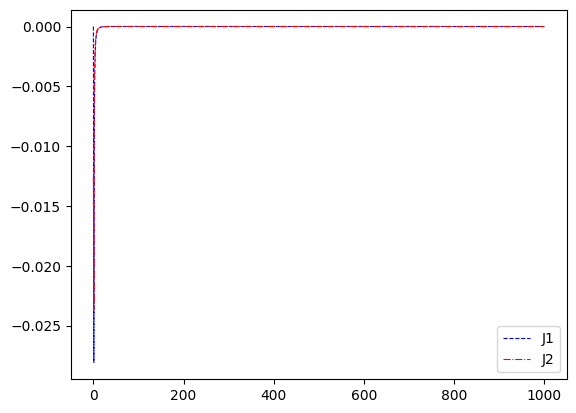

In [2492]:
C_equ   = ufl.inner( k_trial * ufl.grad(u), ufl.grad(p_test)) * ufl.dx
# assemble matrix C
C =  dl.assemble(C_equ)

M_equ   = ufl.inner(k_trial, k_test) * ufl.dx



# assemble matrix M
M = dl.assemble(M_equ)
M_u = dl.assemble(M_equ)
C_tilde = np.linalg.solve(M.array(), C.array().T).T

C_ = C.array()[1:-1,1:-1]
J =   (C.array().T @ adjoint).T
#J =   (C_tilde.T @ adjoint).T
#J_2 = adjoint_2.T @ C.array()
#J = np.linalg.inv(M.array().T) @   C.array().T @ adjoint
J_2 =   (np.linalg.solve(M.array() ,  C.array().T @ adjoint_2)).T
# print(C.array().shape, adjoint.shape, adjoint_2.shape, M.array().shape , J.shape, J_2.shape)
#print(J_2)
# print(C.array().T)
A_P_1 = state_A.array() @ adjoint
A_P_1[np.abs(A_P_1)<1e-10]=0
A_P = state_A.array() @  adjoint_2.T
print( np.round(np.linalg.inv(M.array()) @ A_P))
AJ_C = A_P @ C_tilde  + C_tilde
AJ_C[np.abs(AJ_C)<1e-10]=0
print (A_P_1)
#J = C.array().T @ adjoint
#print(J)
#J_3 = adjoint_3 @ C_.T
plt.plot(np.diag(J),label="J1",linestyle="--",  color="blue" ,linewidth=0.8)
plt.plot(np.diag(J_2) ,label="J2",linestyle="-.",  color="red" ,linewidth=0.8)
#plt.plot(np.diag(J_3) ,label="J3",linestyle="-.",  color="pink" ,linewidth=0.8)

plt.legend()


# True gradient is calcualted as
$$u(x, k) = -\frac{x^3}{6k} + (1 + \frac{1}{6k})x$$
$$\frac{du}{dk} = \frac{\partial u}{\partial k} + \frac{\partial u}{\partial x} \frac{dx}{dk}$$
Since k is independent of x, $\frac{dx}{dk} =0 $, we can write
$$\frac{du}{dk} = \frac{\partial u}{\partial k} $$
$$\frac{du}{dk} = \frac{x^3}{6k^2} -  \frac{x}{6k^2}$$

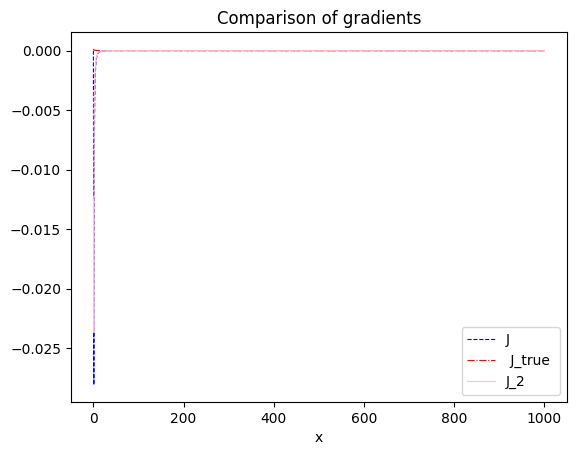

In [2475]:
#du_dk = (x_coord**3 - x_coord)/(6 * ktrue.vector().get_local() * ktrue.vector().get_local())
#du_dk = - x_coord/2 + 0.5 + 3/(np.log(16) * (1+x_coord)) 
du_dk = - x_coord / (2 * a.values() * a.values()) + 1/(2 * a.values() * a.values() * a.values()) +\
    + (1/(np.log(1 + a.values()) * (1 + a.values()* x_coord)) ) * (1/a.values() + 1/(4*a.values()*a.values()) - 1/(2 * a.values() * a.values() * a.values())) 
        
plt.plot(np.diag(J),label="J",linestyle="--",  color="blue" ,linewidth=0.8)
plt.plot(du_dk, label=" J_true ",linestyle="-.",  color="red" ,linewidth=0.8)
plt.plot(np.diag(J_2), label="J_2",linestyle="-",  color="pink" ,linewidth=0.8)

plt.xlabel("x")
plt.title("Comparison of gradients")
plt.legend()
plt.show()

In [2476]:
def error_norm(v1, v2):
    error = np.linalg.norm(v1-v2) / np.linalg.norm(v2)
    return error
error_norm(np.diag(J)[100:-1], du_dk[100:-1]) 

0.8215055752032541

In [2477]:
# for i in range(C_.shape[1]):
#     plt.plot((A_ @ J_3[:,i] + C_.T[:,i]))

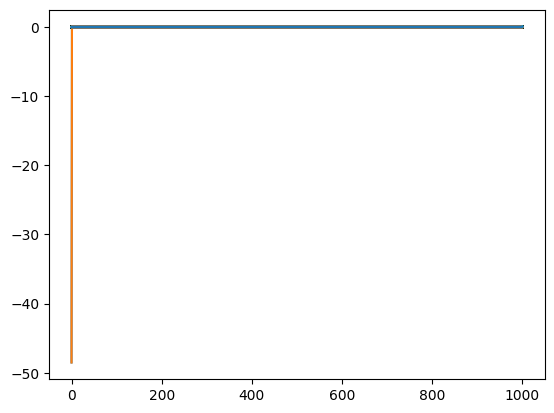

In [2478]:
for i in range(C.array().shape[1]):
    plt.plot((state_A.array() @ J[:,i] + C.array()[:,i]))
    #plt.plot((state_A.array() @ J[:,i] + C_tilde[:,i]))
    

In [2479]:
J_2.shape, state_A.array().shape

((1001, 1001), (1001, 1001))

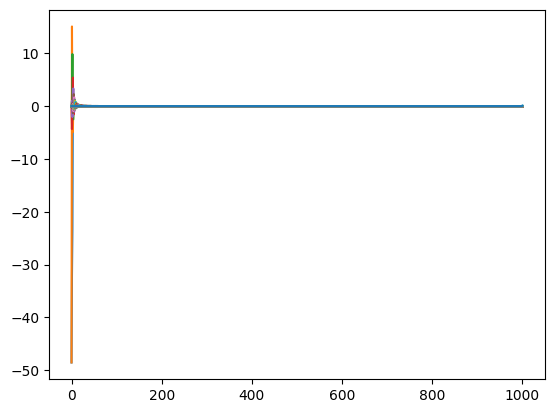

In [2480]:
for i in range(C.array().shape[1]):
    #plt.plot((state_A.array() @ J_2[:,i] + C_tilde[:,i]))
    plt.plot((state_A.array() @ J_2[:,i] + C.array()[:,i]))